In [11]:
from IPython.display import HTML, display
import tabulate
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
sys.setrecursionlimit(round(10**6))

def setupPlot():
    plt.minorticks_on()
    plt.grid(b=True, which='both',color='#D3D3D3', linestyle='-', alpha=0.3)
    plt.legend(loc="upper left")
    plt.ylabel('T(n)')
    plt.xlabel('n')
    
def flushPrintLine():
    print(f"                                                                 ",end='\r')

## Kode for tidsmålinger

In [16]:
def take_time_of(function, args):
    
    start = time.time()
    time_taken = 0
    repeats=0
    min_accuracy = 0.1
    
    while True:
        function(*args)
    
        repeats = repeats + 1
        time_taken = time.time() - start
        if time_taken > min_accuracy: break
    
    return time_taken / repeats 

In [17]:
def compare(functions, names, gen_args, **kwargs):

#   initialize vars
    total_steps = kwargs.get('steps', 5)
    scale = kwargs.get('scale', 3)
    max_operations = round(10**scale)
    step_length = max_operations / total_steps
    operations = [round(s * step_length) for s in range(total_steps)]   
    
    results = []
    colors = ['r','b','g','c','m','y']
 
    
#   going trough every function  
    for i in range(len(functions)):
        
#       calculate times at different (n) complexities
        data = []
        for step in range(total_steps):
            
            n = operations[step]
            arguments = gen_args(n)
            function = functions[i]
         
            print(f"Loading: {names[i]} | {step}/{total_steps} | n = {n}",end='\r')
            
            data.append( take_time_of(function, arguments) )
            
        plt.plot(operations, data, colors[i] + 'o--', label=names[i])
        results.append(data)
    
#   remove loading text
    flushPrintLine()
    
#   display plot
    if 'title' in kwargs: plt.title(kwargs.get('title'))
    setupPlot()
    plt.show()
    
#   display table with data
    headers = ["Operations", *names]
    data = zip(operations, *results)
    display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

## Single pivot quicksort

In [12]:
def quicksort(arr):

    length = len(arr)
    
    if length < 2: return arr
    
#   pick first element as pivot
    pivot_position = 0
    pivot = arr.pop(pivot_position)
    
    less_than_pivot = []
    more_than_pivot = []
    
    for i in arr:
        if i < pivot: less_than_pivot.append(i)
        else:         more_than_pivot.append(i)
            
    return quicksort(less_than_pivot) + [pivot] + quicksort(more_than_pivot)

## Dual pivot quicksort

In [13]:
def dp_quicksort(arr):

    length = len(arr)
    
    if length < 2: return arr

    piv_a_pos = 0
    piv_a = arr.pop(piv_a_pos)
    
    piv_b_pos = length-2
    piv_b = arr.pop(piv_b_pos)

#   swap values if pivot A is bigger than B
    if piv_b < piv_a:
        piv_a_pos, piv_b_pos = piv_b_pos, piv_a_pos
        piv_a, piv_b = piv_b, piv_a
    
    less_than_piv = []
    between_piv = []
    more_than_piv = []
    
    for i in arr:
        if piv_a < i < piv_b: between_piv.append(i)
        elif piv_b <= i: more_than_piv.append(i)
        else: less_than_piv.append(i)
    
    return dp_quicksort(less_than_piv) + [piv_a] + dp_quicksort(between_piv) + [piv_b] + dp_quicksort(more_than_piv)

# Tidsmålinger
I dette arbeidskravet er to varianter av quicksort (single-pivot og dualpivot) sammenlignet med forskjellige type arrays

## Tilfeldige Tall Array Tidsmålinger

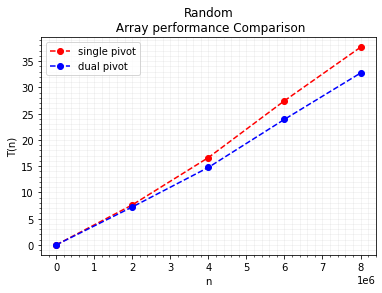

Operations,single pivot,dual pivot
0,3.68385e-07,3.58135e-07
2000000,7.62111,7.2234
4000000,16.6317,14.757
6000000,27.4592,23.9164
8000000,37.6559,32.7421


In [19]:
def random_list(n):
    return [[round(randrange(n)) for i in range(n)]]


compare([quicksort,dp_quicksort],
        ["single pivot","dual pivot"],
        random_list,
        scale= 7, steps= 5, title="Random\n Array performance Comparison")

## Mange duplikater Array Tidsmålinger

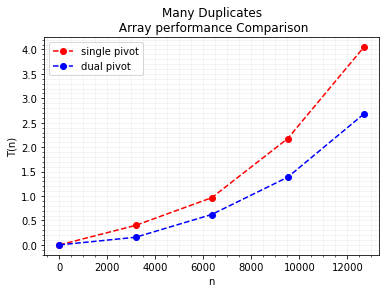

Operations,single pivot,dual pivot
0,3.81465e-07,3.6598e-07
3170,0.399263,0.15655
6340,0.965075,0.621708
9509,2.17623,1.38529
12679,4.04582,2.6787


In [25]:
def duplicates_list(n):
    return [[ i if i%2 == 0 else 13 for i in range(n)]]

compare([quicksort,dp_quicksort],
        ["single pivot","dual pivot"],
        duplicates_list,
        scale=4.2, title="Many Duplicates\n Array performance Comparison")

## Forhåndssortert Array Tidsmålinger

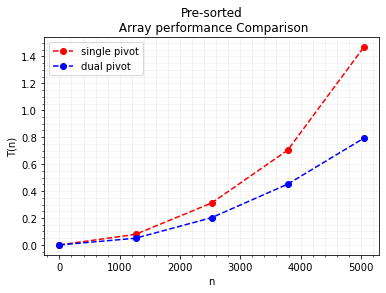

Operations,single pivot,dual pivot
0,3.75436e-07,3.72501e-07
1262,0.0782903,0.0495447
2524,0.311315,0.202458
3786,0.703709,0.451234
5048,1.46812,0.792434


In [29]:
def sorted_list(n):
    return [list(range(n))]

compare([quicksort,dp_quicksort],
        ["single pivot","dual pivot"],
        sorted_list,
        scale=3.8, steps = 5, title="Pre-sorted\n Array performance Comparison")

## Tidsmålinger Sammenlignet

In [34]:
n = 5000

array_types = [random_list, duplicates_list, sorted_list]
args = [array_types[i](n) for i in range(len(array_types))]

headers = ["Array type", "Single pivot", "Dual pivot"]
arr_type = ["Random", "Duplicates", "Sorted"]
single_piv = [ round(take_time_of(quicksort, a),4) for a in args ]
dual_piv = [ round(take_time_of(dp_quicksort, a),4) for a in args ]

display(HTML(tabulate.tabulate(zip(arr_type, single_piv, dual_piv), headers, tablefmt='html')))

Array type,Single pivot,Dual pivot
Random,0.0096,0.0081
Duplicates,0.6031,0.383
Sorted,1.2109,0.7742


## Konklusjoner
Som forventet er min enkle quicksort algoritme ikke optimalisert og har derfor værre ytelse på den forhåndssorterte og mange duplikater array, imens en array med tilfeldige tall har mye bedre ytelse. Vi ser også at dual-pivot slår ut single-pivot variasjonen etter array størrelsen blir tilstrekkelig større.

-------------
## Noen Tester

In [37]:
def test_function(name,func,list_gen_args,tests):
    n = 10**2
    
    results = []
    for test in tests:
        for gen_args in list_gen_args:
            args = gen_args(n)
            passed = test(func, *args)
            if not passed:
                print(f"❌ {name} failed")
                return
            
    print(f"✅ {name} passed")

In [39]:
def checksum(func, arr):
    return sum(arr) == sum(func(arr))

def checkorder(func, arr):
    sort = func(arr)
    for i in range(len(arr) - 1): 
        if sort[i+1] < sort[i]: 
            return False
    
    return True

tests = [checksum, checkorder]
list_types = [random_list,duplicates_list,sorted_list]
test_function("Single pivot quicksort",quicksort, list_types, tests)
test_function("Dual pivot quicksort",dp_quicksort, list_types, tests)

✅ Single pivot quicksort passed
✅ Dual pivot quicksort passed
